In [220]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [221]:
df = pd.read_excel("Data/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [209]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Data Preprocessing
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [210]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [211]:
furniture.head(10)

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940
4938,2014-01-13,333.999
6474,2014-01-14,61.960
970,2014-01-16,127.104
5465,2014-01-19,181.470
6327,2014-01-20,272.940


In [212]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### Indexing with Time Series Data

In [213]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

- Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [214]:
y = furniture['Sales'].resample('MS').mean()

- Have a quick peek 2017 furniture sales data.

In [215]:
y['2017']

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Visualizing Furniture Sales Time Series Data

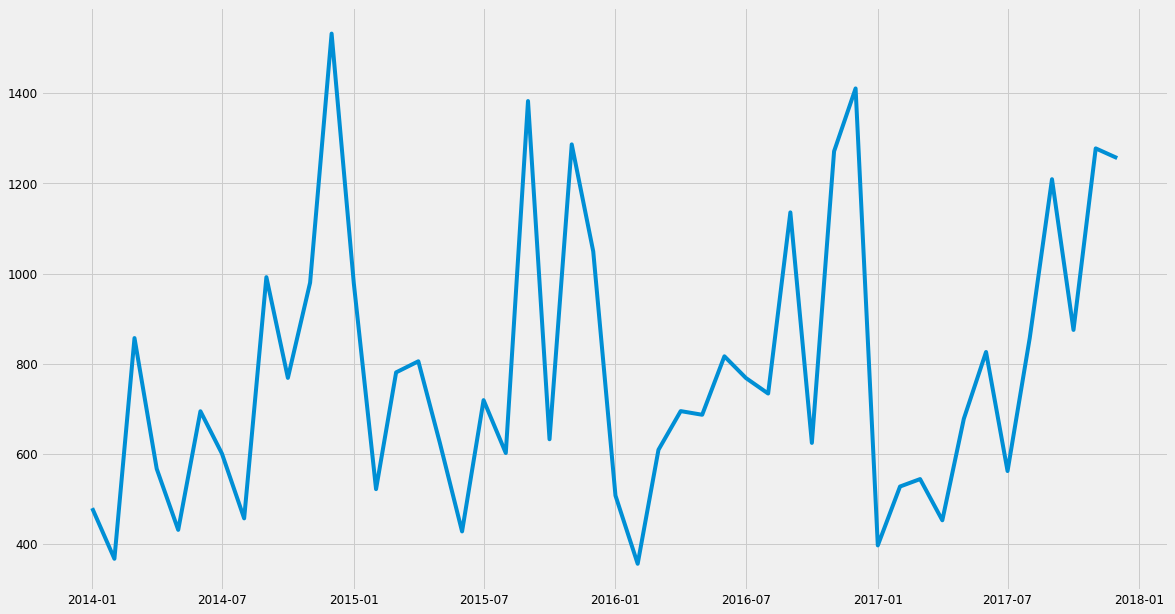

In [219]:
plt.plot(y)
plt.show()

- Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
- We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

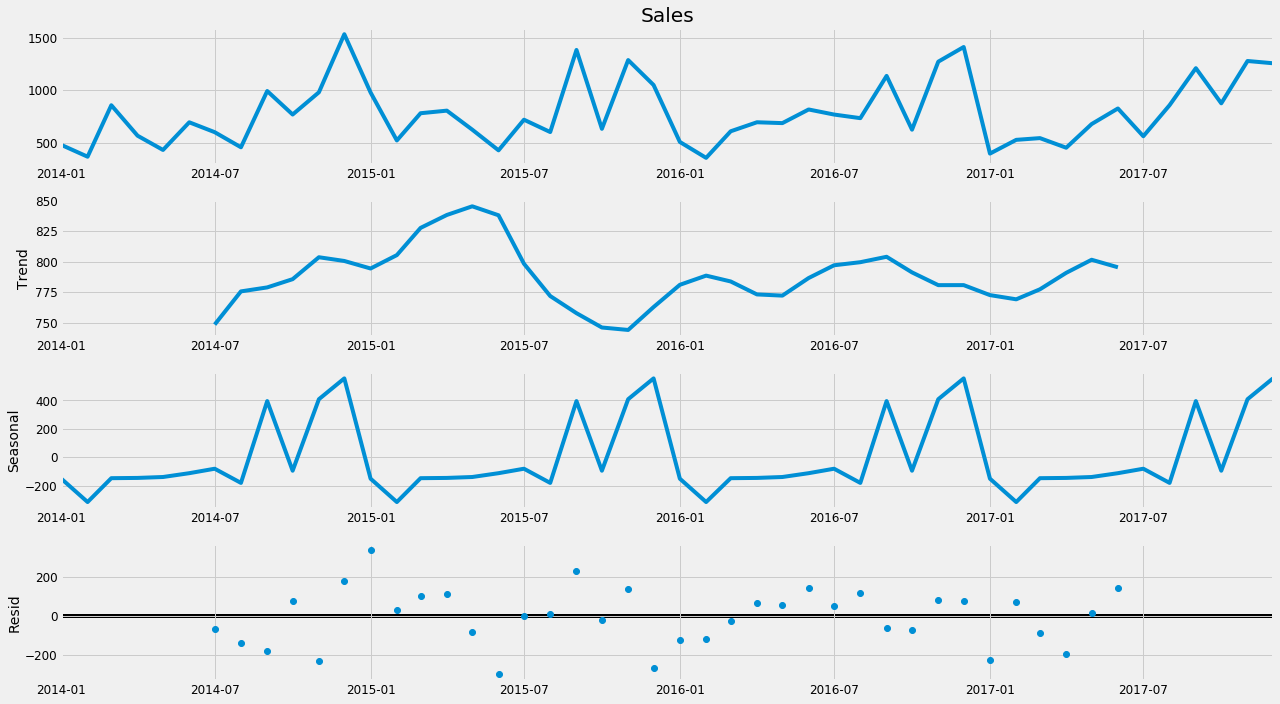

In [146]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

* The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

### Time series forecasting with ARIMA

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [147]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [148]:
# aicVal=[]

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
            
#             results = mod.fit()
            
#             aicVal.append([param, param_seasonal, results.aic, results.bic])

#         except:
#             continue

In [149]:
opt = pd.DataFrame(aicVal, columns=["ARIMA_parameters", "seasonal_parameters", "AIC", "BIC"])
opt.sort_values("AIC")

,ARIMA_parameters,seasonal_parameters,AIC,BIC
186,"(0, 2, 0)","(2, 2, 0, 12)",6.000000e+00,NaN
105,"(0, 1, 0)","(2, 2, 0, 12)",6.000000e+00,NaN
8,"(0, 0, 0)","(0, 2, 2, 12)",6.000000e+00,NaN
24,"(0, 0, 0)","(2, 2, 0, 12)",6.000000e+00,-inf
170,"(0, 2, 0)","(0, 2, 2, 12)",6.000000e+00,NaN
...,...,...,...,...
298,"(1, 0, 2)","(0, 0, 1, 12)",2.507893e+08,2.507893e+08
280,"(1, 0, 1)","(1, 0, 1, 12)",NaN,NaN
307,"(1, 0, 2)","(1, 0, 1, 12)",NaN,NaN
514,"(2, 0, 1)","(0, 0, 1, 12)",NaN,NaN


In [150]:
opt[(opt["AIC"]>0)&(opt["BIC"]>0)].sort_values("AIC").head(20)

,ARIMA_parameters,seasonal_parameters,AIC,BIC
223,"(0, 2, 2)","(0, 2, 1, 12)",96.600215,96.383856
232,"(0, 2, 2)","(1, 2, 1, 12)",98.833969,98.563520
221,"(0, 2, 2)","(0, 1, 2, 12)",99.043471,98.773021
464,"(1, 2, 2)","(0, 1, 2, 12)",99.383818,99.059279
709,"(2, 2, 2)","(0, 2, 1, 12)",99.822042,99.497503
230,"(0, 2, 2)","(1, 1, 2, 12)",101.110258,100.785719
473,"(1, 2, 2)","(1, 1, 2, 12)",103.359855,102.981226
707,"(2, 2, 2)","(0, 1, 2, 12)",103.449471,103.070842
475,"(1, 2, 2)","(1, 2, 1, 12)",103.950259,103.625720
482,"(1, 2, 2)","(2, 1, 2, 12)",104.484360,104.051641


In [151]:
opt[(opt.ARIMA_parameters==(1,1,1)) & (opt.seasonal_parameters==(1,1,0,12))]

,ARIMA_parameters,seasonal_parameters,AIC,BIC
363,"(1, 1, 1)","(1, 1, 0, 12)",297.787544,302.151714


Selected parameters: 
-   SARIMAX(0, 2, 0)x(2, 2, 0, 12) - lowest AIC value
-   SARIMAX(0, 2, 2)x(0, 2, 1, 12) - lowest AIC value where both AIC and BIC value greater than 0 
-   SARIMAX(1, 1, 1)x(1, 1, 0, 12) - lowest AIC value selected by the author and where p,d,q values range up to 1

### Fitting the ARIMA model

**1 ) SARIMAX(1, 1, 1) x (1, 1, 0, 12)**

In [152]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


* We should always run model diagnostics to investigate any unusual behavior.

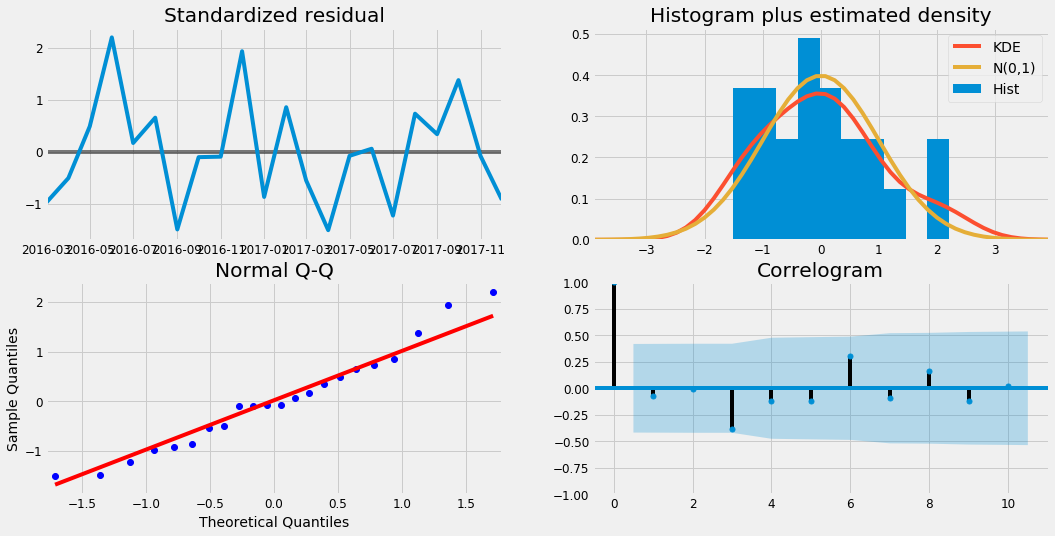

In [153]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

* the model residuals are near normally distributed.

### Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

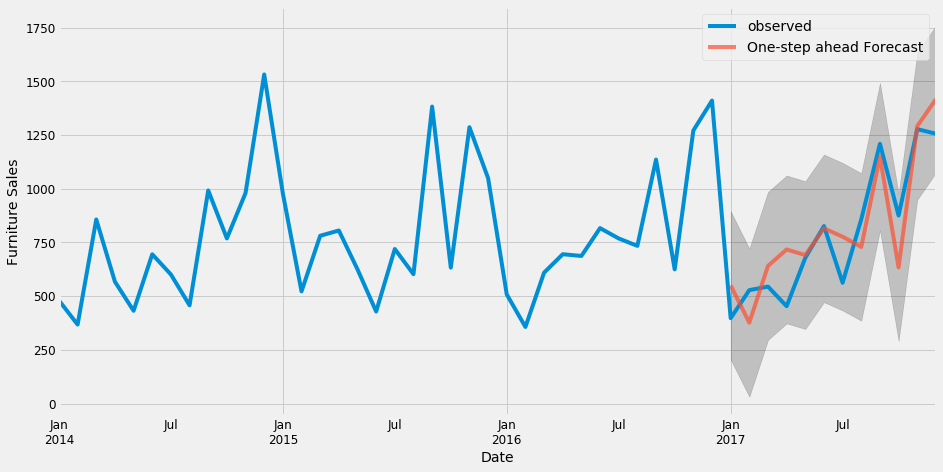

In [154]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

* The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [155]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = mean_squared_error(y_forecasted, y_truth)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [156]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


- In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.
- Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200.

### Producing and visualizing forecasts

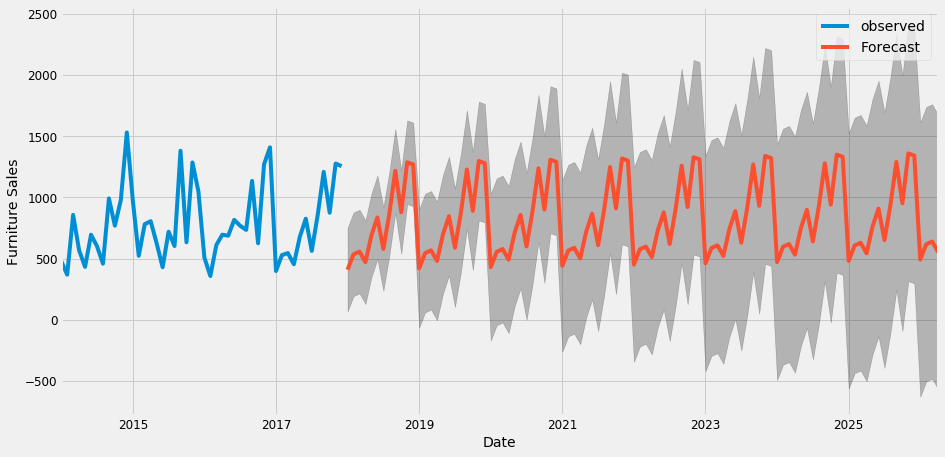

In [157]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

**2 ) SARIMAX(0, 2, 2) x (0, 2, 1, 12)**

In [158]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 2, 2),
                                seasonal_order=(0, 2, 1, 12),
                                enforce_invertibility=False)
                                
                                
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5785      0.326     -4.840      0.000      -2.218      -0.939
ma.L2          0.6277      0.258      2.432      0.015       0.122       1.133
ma.S.L12      -1.0000      0.540     -1.850      0.064      -2.059       0.059
sigma2      8.479e+04   6.37e-06   1.33e+10      0.000    8.48e+04    8.48e+04


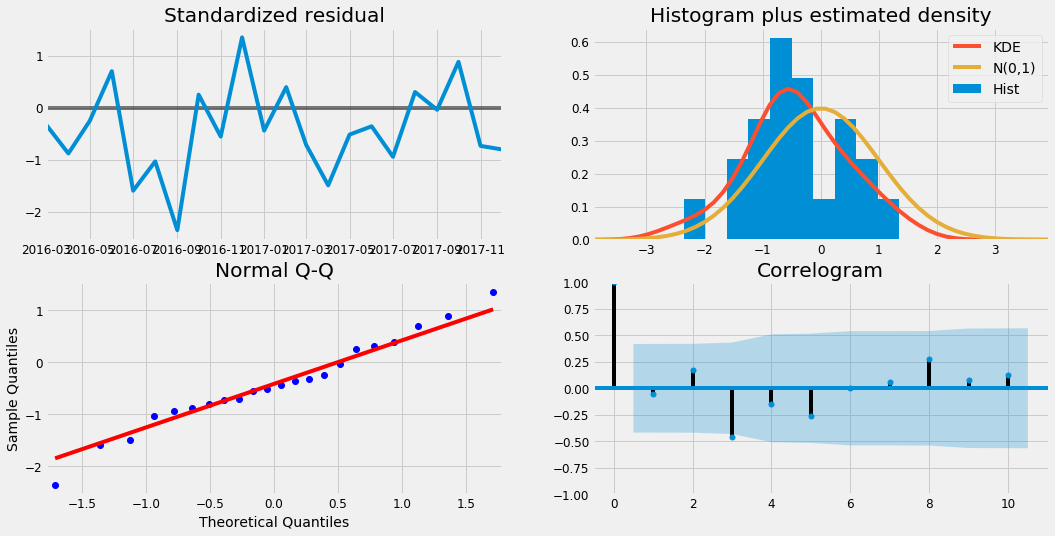

In [159]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

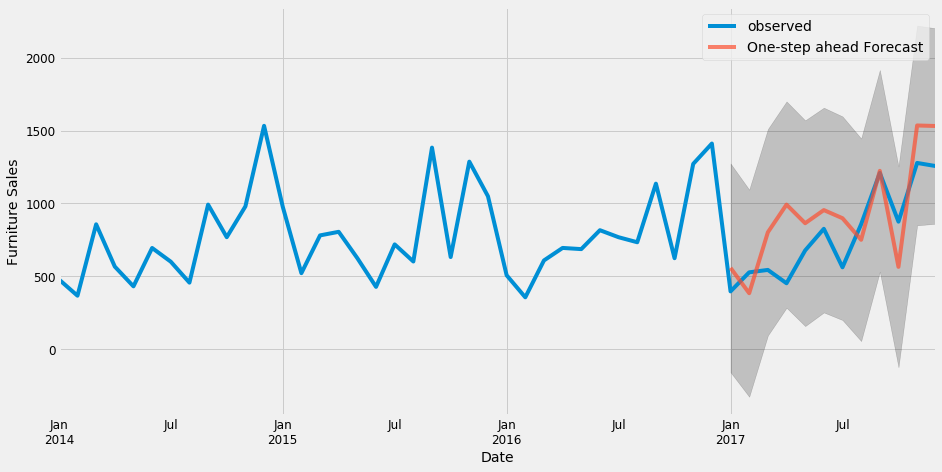

In [160]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [161]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = mean_squared_error(y_forecasted, y_truth)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 68061.52


In [162]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 260.89


**3 ) SARIMAX(0, 2, 0) x (2, 2, 0, 12)**

In [163]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 2, 0),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_invertibility=False)
                                
                                
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9471      0.470     -2.016      0.044      -1.868      -0.026
ar.S.L24      -0.9981      0.002   -629.383      0.000      -1.001      -0.995
sigma2      2759.9146   6.81e-08   4.05e+10      0.000    2759.915    2759.915


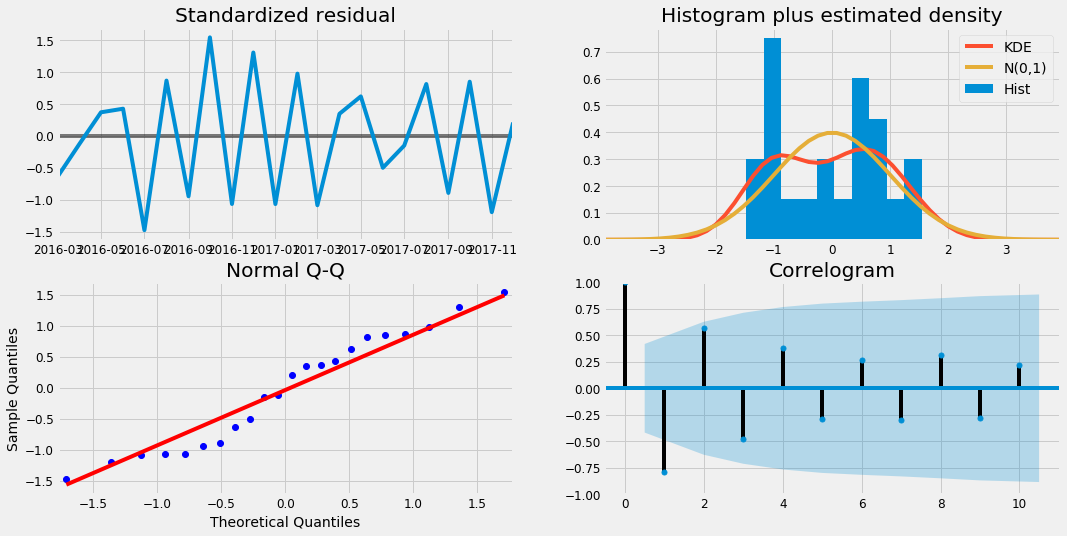

In [164]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

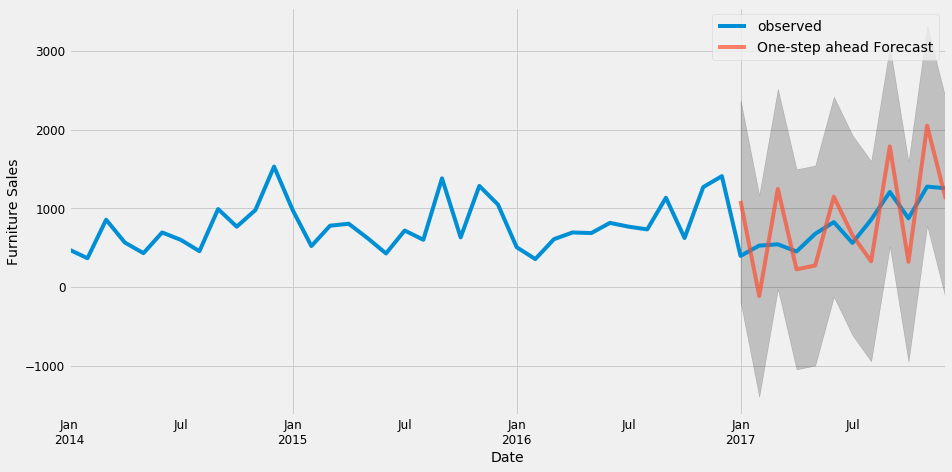

In [165]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [166]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = mean_squared_error(y_forecasted, y_truth)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 271452.9


In [167]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 521.01


* We get the best result with SARIMAX(1, 1, 1) x (1, 1, 0, 12).

### Time Series of Furniture vs. Office Supplies

- there were way more number of sales from Office Supplies than from Furniture over the years.

In [168]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

### Data Exploration
We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [170]:
furniture = furniture[["Order Date", "Sales"]]
furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


In [171]:
office = office[["Order Date", "Sales"]]
office.head()

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900


In [172]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


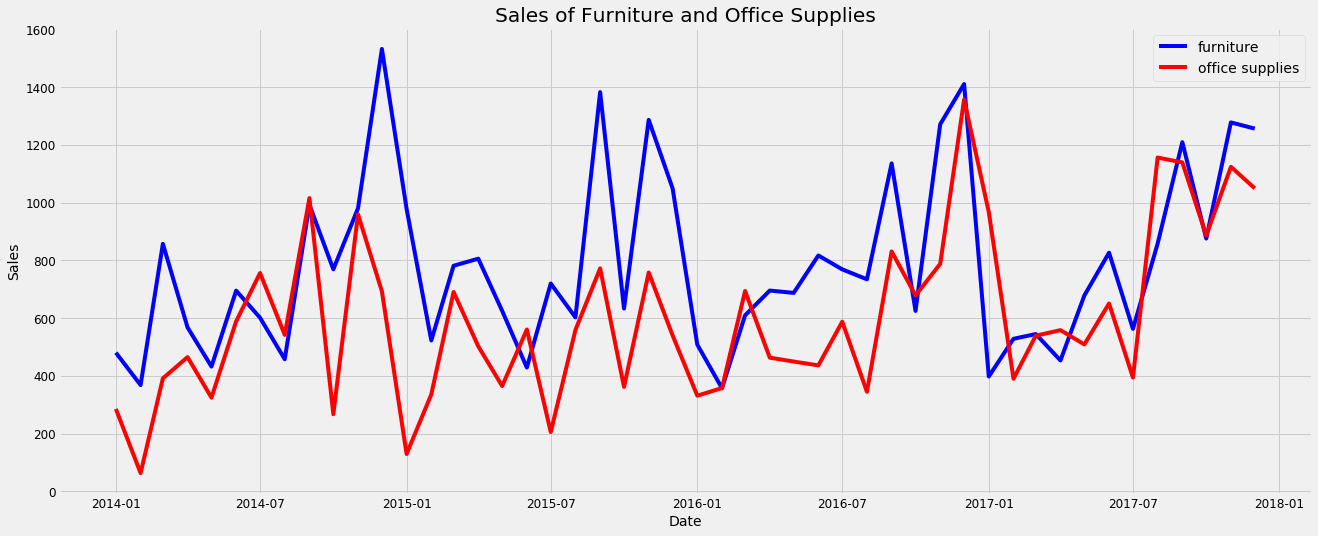

In [173]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales.

Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [175]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Time Series Modeling with Prophet

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

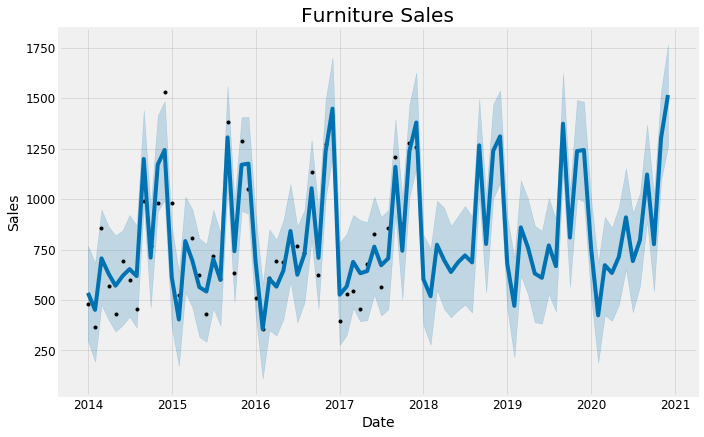

In [178]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')

plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

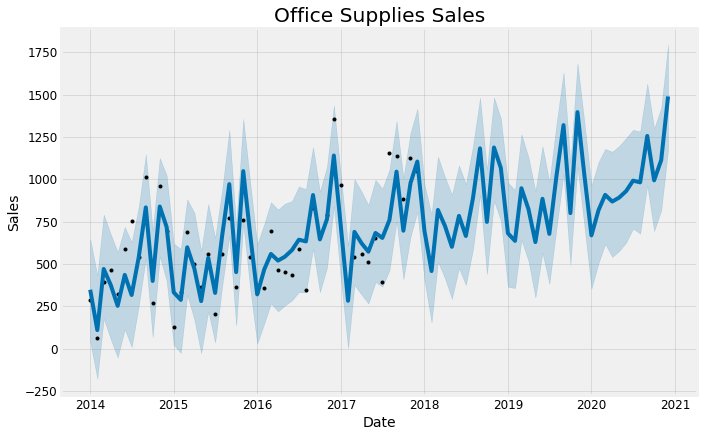

In [179]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [181]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,298.094186,769.165069,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,195.116438,683.312414,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,476.892871,948.375324,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,401.229932,863.830085,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,344.111174,820.496893,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


### Trend and Forecast Visualization

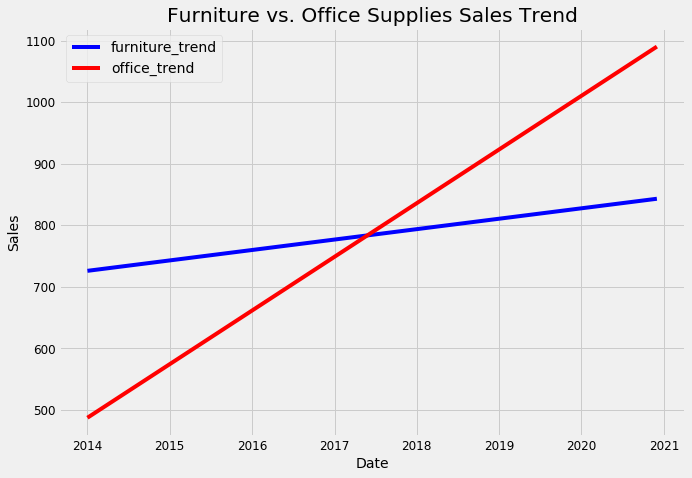

In [184]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label= "furniture_trend")
plt.plot(forecast['Date'], forecast['office_trend'], 'r-', label= "office_trend")
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');
plt.show()

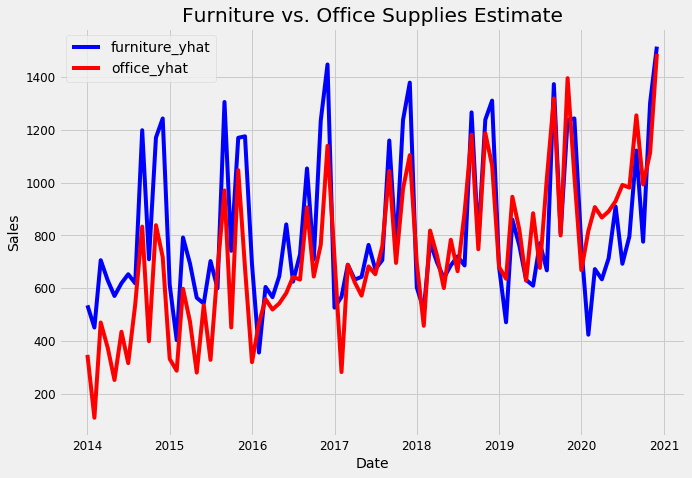

In [186]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label="furniture_yhat")
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-', label="office_yhat")
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

plt.show()

### Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

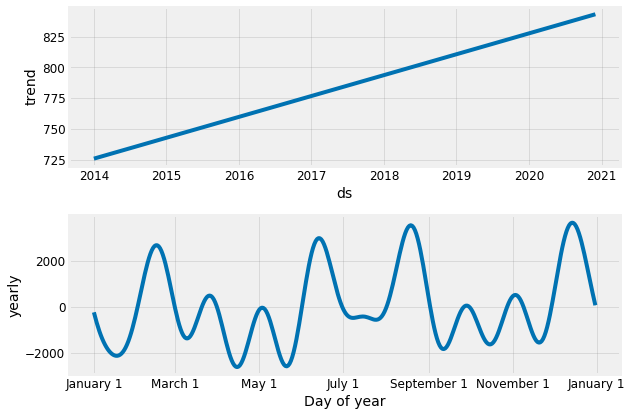

In [188]:
furniture_model.plot_components(furniture_forecast);

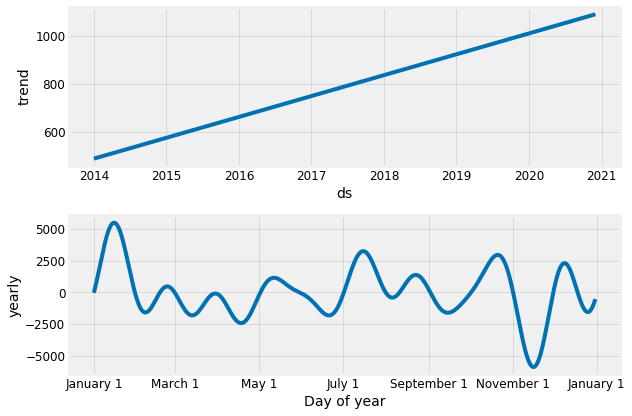

In [189]:
office_model.plot_components(office_forecast);

- Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.
- The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.

Source: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b